In [1]:
from torch import nn
import torch
from sklearn.model_selection import train_test_split
import pandas as pd

In [22]:
device = 'mps' if torch.backends.mps.is_available() else 'cpu'

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
# rpm should be (rpm - idle_rpm)/ max_shift_rpm in order to fit different cars
# must include data when up/down shift to collect more shift data
idle_rpm = 1100
df = pd.DataFrame({'rpm/max': [], 'gas': [], 'brake': [], 'in_first_gear': [], 'in_overdrive': [], 'shift_status': [], 'jump_gears': []})
df.to_csv('data/Normal/data.csv', index=False)
df.columns

Index(['rpm/max', 'gas', 'brake', 'in_first_gear', 'in_overdrive',
       'shift_status', 'jump_gears'],
      dtype='object')

In [ ]:
from pathlib import Path
def csv_update(gas: list, brake: list, rpm_max: list, gear: list, shift_status: list, jump_gears: list, mode: str):
    PATH = Path(f'data/{mode}')
    PATH.mkdir(parents=True, exist_ok=True)
    # Create the CSV file if it doesn't exist
    PATH = Path(f'data/{mode}/data.csv')
    if not PATH.is_file():
        df = pd.DataFrame({'rpm/max': [], 'gas': [], 'brake': [], 'in_first_gear': [], 'in_overdrive': [], 'shift_status': [], 'jump_gears': []})
        df.to_csv(f'data/{mode}/data.csv', index=False)
    new_row = pd.DataFrame({'rpm/max': rpm_max, 'gas': gas, 'brake': brake, 'gear': gear, 'shift_status': shift_status, 'jump_gears': jump_gears})

    # Append the row to the CSV file
    new_row.to_csv(f'data/{mode}/data.csv', index=False, mode='a', header=False)

---

In [23]:
df = pd.read_csv('data/Normal/data.csv')
df

,rpm/max,gas,brake,in_first_gear,in_overdrive,shift_status,jump_gears
0,0.034120,0.070588,0.0,1.0,0,1.0,0
1,0.083415,0.054902,0.0,1.0,0,1.0,0
2,0.102371,0.050980,0.0,1.0,0,1.0,0
3,0.125583,0.086275,0.0,1.0,0,1.0,0
4,0.138657,0.121569,0.0,1.0,0,1.0,0
...,...,...,...,...,...,...,...
3496,0.188790,0.823884,0.0,0.0,1,0.0,1
3497,0.217789,0.782949,0.0,0.0,1,0.0,1
3498,0.365227,0.861438,0.0,0.0,1,0.0,1
3499,0.342704,0.798636,0.0,0.0,1,0.0,1


In [ ]:
# df.loc[df['jump_gears'] == 1 , 'shift_status'] = 0
df.loc[df['jump_gears'] == 1]
df['shift_status'] = df['shift_status'].shift(-1)
df.loc[df['shift_status'] == 0]

In [44]:
jumped = df.loc[df['jump_gears'] == 1]
jumped['rpm/max'].min(), jumped['rpm/max'].max(), jumped['gas'].min(), jumped['gas'].max()

(0.1500568424524147, 0.3665316139223593, 0.7500438356271927, 1.0)

In [3]:
import random
for i in range(600):
    rpm_max = random.uniform(0.15, 0.365316)
    gas = random.uniform(0.75, 1.0)
    brake = 0.0
    in_first_gear = 0.0
    in_overdrive = 1
    shift_status = 0.0
    jump_gears = 1
    new_jump = pd.DataFrame([[rpm_max, gas, brake, in_first_gear, in_overdrive, shift_status, jump_gears]], columns=jumped.columns)
    new_jump.to_csv('data/Normal/jump.csv', mode='a', header=False, index=False)
    

NameError: name 'jumped' is not defined

In [55]:
df = pd.read_csv('data/Normal/data.csv')

In [ ]:
df.loc[df['jump_gears'] == 1 , 'shift_status'] = 0
df.loc[df['jump_gears'] == 1 , 'in_overdrive'] = 1
# df.tail(30)
df.loc[df['jump_gears'] == 1]

In [ ]:

df.loc[df['jump_gears'] == 1]


In [ ]:
df.info(), df.isna().sum()

In [ ]:
df.tail

In [ ]:
# df.to_csv('data/Normal/processed.csv', index=False)

---

## we use shift status as the label and add a jump gear feature ((1 - rpm/max_shift_rpm) / 2.5)

In [ ]:
# df = pd.read_csv('data/Normal/processed.csv')

In [ ]:
df

In [24]:
features = df[['rpm/max', 'gas', 'brake', 'in_first_gear', 'in_overdrive']].values
labels = df[['shift_status', 'jump_gears']].values

<Axes: >

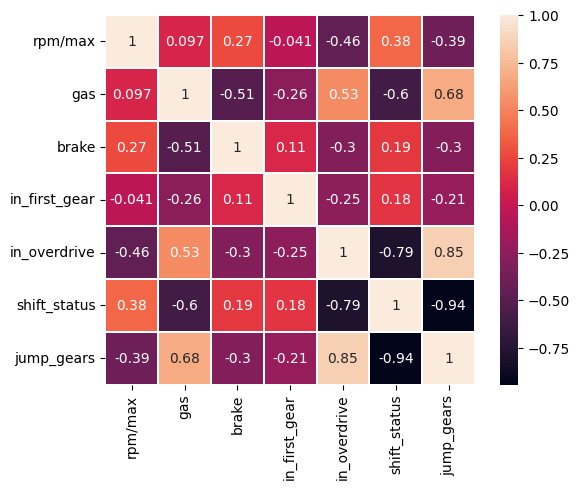

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.heatmap(df.corr(), linewidths=0.1,vmax=1.0, square=True, linecolor='white', annot=True)

In [26]:
Xtrain, Xtest, yTrain, yTest = train_test_split(features, labels, shuffle=True, test_size=0.35)

In [27]:
yTrain[: , 0]

array([0., 1., 0., ..., 0., 0., 0.])

## build model

In [28]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(5, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, 128)
        self.fc5 = nn.Linear(128, 3)  # Output layer for shift status
        self.fc6 = nn.Linear(128, 1)  # Output layer for jump gears or not

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        out1 = self.fc5(x)  # Predicts shift status
        out2 = self.fc6(x)  # Predicts whether to jump gears or not
        return out1, out2

In [29]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [30]:
model = Net().to(device)
criterion1 = nn.CrossEntropyLoss()  # For shift status
criterion2 = nn.BCEWithLogitsLoss() # For jump gears
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.002)

In [31]:
Xtrain = torch.from_numpy(Xtrain).to(torch.float).to(device)
Xtest= torch.from_numpy(Xtest).to(torch.float).to(device)
yTrain = torch.from_numpy(yTrain).to(torch.float).to(device)
yTest= torch.from_numpy(yTest).to(torch.float).to(device)

In [32]:
Xtrain

tensor([[0.2894, 0.8556, 0.0000, 0.0000, 1.0000],
        [0.1579, 0.2745, 0.0000, 0.0000, 0.0000],
        [0.2732, 0.7842, 0.0000, 0.0000, 1.0000],
        ...,
        [0.3340, 0.8456, 0.0000, 0.0000, 1.0000],
        [0.2497, 0.7957, 0.0000, 0.0000, 1.0000],
        [0.2511, 0.8093, 0.0000, 0.0000, 1.0000]], device='mps:0')

In [33]:
yTrain, yTrain[:, 0]

(tensor([[0., 1.],
         [1., 0.],
         [0., 1.],
         ...,
         [0., 1.],
         [0., 1.],
         [0., 1.]], device='mps:0'),
 tensor([0., 1., 0.,  ..., 0., 0., 0.], device='mps:0'))

In [34]:
torch.Tensor([[0.22, 0.85, 0.0, 0.0, 1.0]])

tensor([[0.2200, 0.8500, 0.0000, 0.0000, 1.0000]])

In [35]:
from tqdm.auto import tqdm

epochs = 2000

for epoch in tqdm(range(1, epochs+1)):
    model.train()
    
    shift_logit, jump_logit = model(Xtrain)
    
    shift_prob = torch.softmax(shift_logit, dim=1)
    shift_pred = torch.argmax(shift_prob, dim=1)
    shift_loss = criterion1(shift_logit, yTrain[:, 0])
    shift_acc = accuracy_fn(y_true=yTrain[:, 0], y_pred=shift_pred)

    jump_prob = torch.sigmoid(jump_logit)
    jump_pred = torch.round(jump_prob).squeeze(dim=1)
    jump_loss = criterion2(jump_logit.squeeze(dim=1), yTrain[:, 1])
    jump_acc = accuracy_fn(y_true=yTrain[:, 1], y_pred=jump_pred)

    optimizer.zero_grad()
    shift_loss.backward(retain_graph=True)
    jump_loss.backward()
    optimizer.step()
    
    model.eval()
    with torch.no_grad():
        shift_test_logit, jump_test_logit = model(Xtest)
        
        shift_test_prob = torch.softmax(shift_test_logit, dim=1)
        shift_test_pred = torch.argmax(shift_test_prob, dim=1)
        shift_test_loss = criterion1(shift_test_logit, yTest[:, 0])
        shift_test_acc = accuracy_fn(y_true=yTest[:, 0], y_pred=shift_test_pred)

        jump_test_prob = torch.sigmoid(jump_test_logit)
        jump_test_pred = torch.round(jump_test_prob).squeeze(dim=1)
        jump_test_loss = criterion2(jump_test_logit.squeeze(dim=1), yTest[:, 1])
        jump_test_acc = accuracy_fn(y_true=yTest[:, 1], y_pred=jump_test_pred)

    if epoch % 50 == 0:
        print(f"Epoch: {epoch}\nTrain shift loss: {shift_loss.item():.4f} | Train jump loss: {jump_loss.item():.4f} | Train shift acc: {shift_acc:.2f}% | Train jump acc: {jump_acc:.2f}%\nTest shift loss: {shift_test_loss.item():.4f} | Test jump loss: {jump_test_loss.item():.4f} | Test shift acc: {shift_test_acc:.2f}% | Test jump acc: {jump_test_acc:.2f}%")
    if epoch == epochs+1:
        if shift_test_loss > 0.6 or jump_test_loss > 0.6:
            print('WTF IS THIS SHIT MAN UR DATA SUCKS')


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch: 50
Train shift loss: 1.0262 | Train jump loss: 0.6752 | Train shift acc: 71.82% | Train jump acc: 70.73%
Test shift loss: 1.0223 | Test jump loss: 0.6730 | Test shift acc: 73.98% | Test jump acc: 73.16%
Epoch: 100
Train shift loss: 0.9952 | Train jump loss: 0.6688 | Train shift acc: 71.82% | Train jump acc: 70.73%
Test shift loss: 0.9898 | Test jump loss: 0.6659 | Test shift acc: 73.98% | Test jump acc: 73.16%
Epoch: 150
Train shift loss: 0.9666 | Train jump loss: 0.6628 | Train shift acc: 71.82% | Train jump acc: 70.73%
Test shift loss: 0.9596 | Test jump loss: 0.6592 | Test shift acc: 73.98% | Test jump acc: 73.16%
Epoch: 200
Train shift loss: 0.9403 | Train jump loss: 0.6572 | Train shift acc: 71.82% | Train jump acc: 70.73%
Test shift loss: 0.9318 | Test jump loss: 0.6529 | Test shift acc: 73.98% | Test jump acc: 73.16%
Epoch: 250
Train shift loss: 0.9160 | Train jump loss: 0.6519 | Train shift acc: 71.82% | Train jump acc: 70.73%
Test shift loss: 0.9062 | Test jump loss: 0.

KeyboardInterrupt: 

In [149]:
model.eval()
with torch.no_grad():
    shift_logit, jump_logit = model(torch.Tensor([[0.27, 0.96, 0.0, 0.0, 1.0]]).to(device))
    shift_prob = torch.softmax(shift_logit, dim=1)
    shift_pred = torch.argmax(shift_prob, dim=1)
    jump_prob = torch.sigmoid(jump_logit)
    jump_pred = torch.round(jump_prob).squeeze(dim=1)

In [150]:
shift_pred, jump_pred

(tensor([0], device='mps:0'), tensor([1.], device='mps:0'))

In [151]:
shift_pred.cpu().numpy(), print('ture' if jump_pred == 1 else '')

ture


(array([0]), None)

In [28]:
from pathlib import Path

PATH = Path('MODELS')
PATH.mkdir(exist_ok=True, parents=True)

MODEL_PATH = PATH / 'first_normal_model.pth'
print(f"Saving model to {MODEL_PATH}")
torch.save(model.state_dict(), MODEL_PATH)

Saving model to MODELS/first_normal_model.pth


In [29]:
df = pd.read_csv('data/Normal/data.csv')
df.tail(30)

,rpm/max,gas,brake,in_fitst_gear,in_overdrive,shift_status,jump_gears
3471,0.212277,0.969640,0.0,0.0,1,0.0,1
3472,0.263662,0.983250,0.0,0.0,1,0.0,1
3473,0.329544,0.800316,0.0,0.0,1,0.0,1
3474,0.197189,0.790420,0.0,0.0,1,0.0,1
3475,0.187836,0.906564,0.0,0.0,1,0.0,1
3476,0.335011,0.786484,0.0,0.0,1,0.0,1
3477,0.305478,0.820305,0.0,0.0,1,0.0,1
3478,0.219644,0.942082,0.0,0.0,1,0.0,1
3479,0.216691,0.933313,0.0,0.0,1,0.0,1
3480,0.338228,0.951081,0.0,0.0,1,0.0,1


In [32]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(5, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, 128)
        self.fc5 = nn.Linear(128, 3)  # Output layer for shift status
        self.fc6 = nn.Linear(128, 2)  # Output layer for jump gears or not

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        out1 = self.fc5(x)  # Predicts shift status
        out2 = self.fc5(x)  # Predicts whether to jump gears or not
        return out1, out2

In [36]:
load_model = Net()
load_model.load_state_dict(torch.load(MODEL_PATH, map_location=torch.device('cpu')))

<All keys matched successfully>

In [41]:
load_model.eval()
with torch.no_grad():
    shift_logit, jump_logit = load_model(torch.Tensor([[0.22, 0.95, 0.0, 0.0, 1.0]]))
    shift_prob = torch.sigmoid(shift_logit)
    shift_pred = torch.argmax(shift_prob, dim=1)
    jump_prob = torch.sigmoid(jump_logit)
    jump_pred = torch.argmax(jump_prob, dim=1)

In [42]:
shift_pred, print(6 if jump_pred == 1 else "so sad")

so sad


(tensor([0]), None)

seperate shift and jump gear to two models